(linreg)=
# Linear Regression

Regression should be a familiar topic. We will move quickly through what might be familiar and then introduce machine learning vocabulary and other points of emphasis. Some of this, like discussion of the loss surface, will feel unnecessary. However, this is a chance to ease into new concepts that will arise again for other prediction models. 

```{admonition} Reading
:class: seealso
- {cite}`kuhn2013applied`, Chapter 6
- {cite}`hastie2009elements`, Chapter 3
```

## OLS

Can you think of some famous lines? Maybe you are thinking of the Equator, the Mason Dixon, or the line in the sand at the Alamo. We can do better. $\hat{y} = 68 + \frac{2}{3}(68-x)$ is the line from which we get the term **regression**.

> "The height-deviate of the offspring is, on the average, two-thirds of the height-deviate of its mid-parentage." {cite}`galton1886regression`

Francis Galton found this line by observing that tall parents tended to have shorter (closer to average) children, while short parents tended to have taller kids. He described this phenomenon as "regression to mediocrity," reflecting the tendency of extreme characteristics to move back toward the population average in subsequent generations. Galton actually used "ocular regression" (eyeballing it) and the term *regression* has stuck for the general line-of-best-fit technique, even when applied to data that don't follow this pattern. Regression is also sometimes used to describe any kind of model that predicts a numeric value (for example, a decision tree might be called regression tree).

In 2025, ocular regression doesn't cut it. Ordinary least squares (OLS) is the most common method for estimating the parameters in a linear regression model. Linear models are flexible because they can still accommodate interactions, categorical predictors, and nonlinearities. You, the analyst, just have to include them in your specification. 

Our predictors give us the design matrix, $X$. With $n$ observations and $k$ features (including an intercept), this is $n\times k$. The target variable is stored in the $n\times 1$ matrix, $y$.

Then, we find the regression coefficients $\hat{\beta}$, which might also be called the model **parameters**. Once the parameters are found, we can make predictions $X\hat{\beta}$ and $y-X \hat{\beta}$ is the vector of **residuals** or prediction errors. 

### Optimization

Parameters for any model are found by minimizing a **loss function** (also called a cost function[^2]), which describes the quality of the model fit for particular parameter values. The parameters are found by minimizing the loss $L(\beta)$,

$$ \hat{\beta} = \arg\min_{\beta} \left[ L(\beta) \right].$$

[^2]: Cost and loss are use interchangeably but one might insist that the loss function is the individual function for each data point and the cost is the loss aggregated over all data points. 


For least squares,

$$ \hat{\beta} = \arg\min_{\beta} \sum_{i=1}^n (y_i - x_i^T\beta)^2$$


$\hat{\beta}$ is simply where we find the minimum of $L(\beta)$ loss surface. The plot below illustrates such a surface for simple linear regression. Each point in the contour plot corresponds to an entirely different line of fit. 

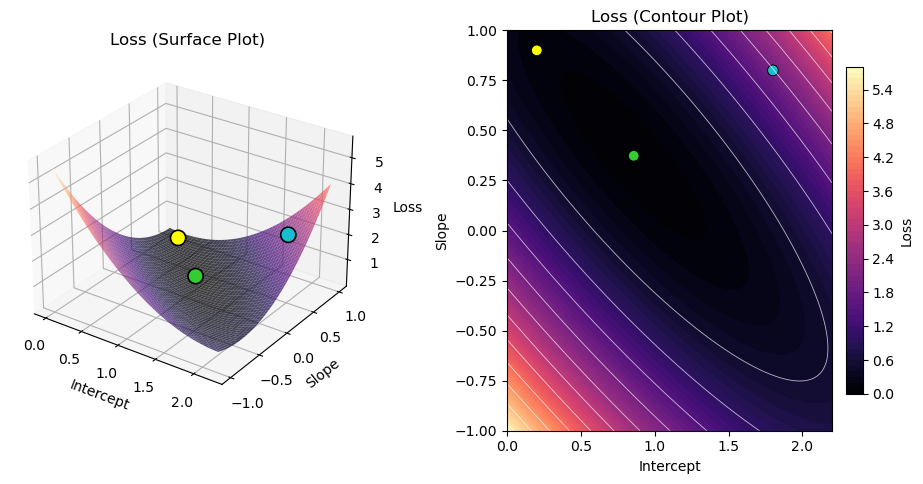

In [85]:
# hide code, show output
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

# --- data ---
rng = np.random.default_rng(3)
x = np.linspace(0, 2, 20)
y = 0.9 + 0.35 * x + rng.normal(0, 0.15, len(x))

X = np.c_[np.ones_like(x), x]
phi0_hat, phi1_hat = np.linalg.lstsq(X, y, rcond=None)[0]

phi0 = np.linspace(0, 2.2, 200)
phi1 = np.linspace(-1.0, 1.0, 200)
P0, P1 = np.meshgrid(phi0, phi1)
res = y[:, None, None] - (P0[None, ...] + P1[None, ...] * x[:, None, None])
L = (res**2).mean(axis=0)

cand = np.array([[0.2, 0.9],
                 [1.8, 0.8],
                 [phi0_hat, phi1_hat]])
cand_losses = np.array([((y - (c0 + c1*x))**2).mean() for c0, c1 in cand])

# --- plot ---
fig = plt.figure(figsize=(11, 5.2))

# (a) 3D loss surface
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(P0, P1, L, rstride=4, cstride=4, cmap='magma',
                        linewidth=0, antialiased=True, alpha=0.75)
surf.set_zsort('min')          # draw far facets first
ax1.set_xlabel('Intercept'); ax1.set_ylabel('Slope'); ax1.set_zlabel('Loss')
ax1.set_title('Loss (Surface Plot)')
ax1.view_init(elev=28, azim=-55)

# (b) heatmap + isocontours
ax2 = fig.add_subplot(1, 2, 2)
im = ax2.contourf(P0, P1, L, levels=60, cmap='magma')
ax2.contour(P0, P1, L, levels=12, colors='white', linewidths=0.6, alpha=0.7)
ax2.scatter(cand[:,0], cand[:,1], s=60,
            c=['yellow','tab:cyan','limegreen'],
            edgecolors='k', linewidths=0.7)
ax2.set_xlabel('Intercept'); ax2.set_ylabel('Slope')
ax2.set_title('Loss (Contour Plot)')
cbar = fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('Loss')

plt.subplots_adjust(wspace=0.4)
fig.canvas.draw()  # finalize layout/projection before overlay

# -------- overlay markers on 3D axes (robust; no tight-bbox errors) --------
# project 3D points to 2D in ax1's data coordinates
x2, y2, _ = proj3d.proj_transform(cand[:,0], cand[:,1], cand_losses, ax1.get_proj())

# create a plain Axes that exactly overlaps ax1 (no locator; excluded from layout)
bbox = ax1.get_position()
ax_overlay = fig.add_axes(bbox, frameon=False)
ax_overlay.set_axis_off()
ax_overlay.set_in_layout(False)

# convert display pixels -> overlay's axes fraction and draw there
xy_disp = ax1.transData.transform(np.c_[x2, y2])
xy_axes = ax_overlay.transAxes.inverted().transform(xy_disp)
ax_overlay.scatter(xy_axes[:,0], xy_axes[:,1], s=120,
                   transform=ax_overlay.transAxes,
                   c=['yellow','tab:cyan','limegreen'],
                   edgecolors='k', linewidths=1.2, clip_on=True)

plt.show()


The optimization is straightforward for OLS. The loss minimizing $\hat{\beta}$ is

$$\hat{\beta} = (X^TX)^{-1} X^T y.$$


Because linear algebra is king in machine learning, we'll give the geometric interpretation. OLS solves a projection problem:

* The column space of $X$ is the set of all possible predictions we can make using linear combinations of our features. This forms a $k$-dimensional subspace in $\mathbb{R}^n$.
* Our observed $y$ vector typically doesn't lie exactly in this column space (for example, for three points that you can't draw a single line through in simple linear regression).
* OLS finds $\hat{\beta}$ such that $X\hat{\beta}$ is the vector of predictions in the column space closest to $y$.
* $X\hat{\beta}$ is not the regression line. The regression line (or hyperplane) is the set of all points $(x_1, \dots ,x_{k-1}, x^T\hat{\beta})$. 

Mathematically, $X\hat{\beta}$ is the orthogonal projection of $y$ onto the column space of $X$. Orthogonality is what makes $X\hat{\beta}$ closer to $y$ than any other candidate:

$$\Vert y - X\hat{\beta} \Vert \leq \Vert y - Xv \Vert.$$

for any other $k \times 1$ vector $v$. In other words, no other choice of coefficients can get us closer to $y$.

The quality of the fit is not generally measured by $\Vert y - X\hat{\beta} \Vert$.[^1] Instead we usually report the mean squared error (MSE),

[^1]: $\Vert \cdot \Vert$ is the Euclidean or L2 norm. 

$$ \mathrm{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 = \frac{1}{n}\Vert y - X\hat{\beta} \Vert^2.$$

This scaling makes MSE comparable across datasets of different sizes.



## Feature Engineering

Once you have fixed the set of predictor variables (and thus the design matrix $X$), there is no **tuning** to do for OLS. The important choice for OLS is what variables (or transformations of variables) to include. The process of refining your set of predictor variables (features) is called **feature engineering**. 

You should already be familiar with feature engineering, if not by that name. Review {cite}`kuhn2013applied` Chapter 3 for an overview of variable transformations. Let's cover a few. 

### Standardization


### Normalization


### One-hot encoding


### Principal Components
